In [1]:
import pandas as pd
import sys 
import csv
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from CASutils import calendar_utils as cal
from CASutils import mapplot_utils as maps
from math import nan as nan

In [2]:
ystart=1979 ; yend=2020 ; nyears=yend-ystart+1

In [3]:
### Setting up the output calendar dates
timeout = pd.date_range(start=str(ystart)+"-01-01",end=str(yend)+"-12-31")
### Remove Feb 29th
timeout = timeout[~((timeout.month == 2) & (timeout.day == 29))]

In [4]:
monstrings=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
datpath="/project/mojave/observations/ISD/global-summary-of-the-day/archive/"
statfile="/project/mojave/observations/ISD/global-summary-of-the-day/isd-history.txt"
inventfile="/project/mojave/observations/ISD/global-summary-of-the-day/isd-inventory.csv"
fileout="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/ISD/1980_2020/T2M_DEW_ISD_global_1980_2020.nc"

### Set up the character locations of required columns from the idf-history.txt file

In [5]:
datestart=[82,90] 
dateend=[91,99]
latstr=[57,64]
lonstr=[65,73]
usafstr=[0,6]
wbanstr=[7,12]

### Open the isd-history file and grab out the relevant station information

In [6]:
f = open(statfile,"r")
# skip header
for i in range(22):
    f.readline()

#sys.exit()
usaf=[] ; wban=[] ; dates=[] ; datee=[] ; lon=[] ; lat=[]
count=0
for line in f:
    dates.append(line[datestart[0]:datestart[1]])
    datee.append(line[dateend[0]:dateend[1]])
    lon.append(line[lonstr[0]:lonstr[1]])
    lat.append(line[latstr[0]:latstr[1]])
    usaf.append(line[usafstr[0]:usafstr[1]])
    wban.append(line[wbanstr[0]:wbanstr[1]])
f.close()

In [7]:
dictstat=[{'wban': wban, 'usaf': usaf, 'lat': lat, 'lon':lon, 'dates':dates, 'datee':datee} for wban, usaf, lat, lon, dates, datee in zip (wban, usaf, lat, lon, dates, datee)]

In [8]:
inventory = pd.read_csv(inventfile)

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
statuse=[]
statname=[]
usaf=[]
wban=[]
latstation=[]
lonstation=[]

for key in dictstat:
    try:
        latflt=float(key['lat'])
    except:
        latflt=-9999.
        
    try: 
        lonflt=float(key['lon'])
    except:
        lonflt=-9999.
        
    try:
        usafval = int(key['usaf'])
    except:
        usafval = key['usaf']
        
    inventdat = inventory.loc[inventory['USAF']==usafval]
    statyears = inventdat.loc[(inventdat['YEAR'] >= ystart) & (inventdat['YEAR'] <= yend)]
    statyears = statyears['YEAR']
    
    datebegflt = float(key['dates'])
    dateendflt = float(key['datee'])
    
    if (  (datebegflt < ystart*10000) and (dateendflt >= (yend*10000+1)) and (len(statyears) == nyears)):
        statuse.append(key)
        statname.append(key['usaf']+key['wban'])
        usaf.append(key['usaf'])
        wban.append(key['wban'])
        latstation.append(latflt)
        lonstation.append(lonflt)

In [14]:
print(statuse.loc['usaf'])

AttributeError: 'list' object has no attribute 'loc'

In [19]:
print(inventory)

          USAF   WBAN  YEAR   JAN   FEB   MAR   APR   MAY   JUN   JUL   AUG  \
0         7018  99999  2011     0     0  2104  2797  2543  2614   382     0   
1         7018  99999  2013     0     0     0     0     0     0   710     0   
2         7026  99999  2012     0     0     0     0     0     0   367     0   
3         7026  99999  2014     0     0     0     0     0     0   180     0   
4         7026  99999  2016     0     0     0     0     0   794     0     0   
...        ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
656114  A51256    451  2017  2192  1883  2204  1910  2145  2113  2218  2204   
656115  A51256    451  2018  2192  1887  2194  2113  2151  2095  2202  2197   
656116  A51256    451  2019  2188  2000  2143  2105  2187  2124  2184  2138   
656117  A51256    451  2020  2165  1455  2144  2125  2199  2123  2112  2192   
656118  A51256    451  2021  1515     0     0     0     0     0     0     0   

         SEP   OCT   NOV   DEC  
0          0     0

In [17]:
print(len(statuse))

3392


In [18]:
print(statuse[3391])

{'wban': '99999', 'usaf': '988360', 'lat': '+06.922', 'lon': '+122.060', 'dates': '19450312', 'datee': '20210124'}


In [11]:
print(len(statuse))


3392


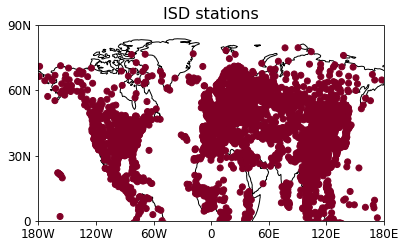

In [10]:
fig = plt.figure(figsize=(16,16))

ax1 = maps.contourmap_bothcontinents_scatter_nh_pos(fig, np.ones([len(lonstation)]), lonstation, latstation, 0.1,-1,1,'ISD stations',
                                                    0.02,0.32,0.8,0.97)

In [11]:
datevals=pd.date_range(start="1979-01-01",end="1979-12-31")
m = np.array(datevals.month)
mm = np.char.zfill(m.astype(str),2)
d = np.array(datevals.day)
dd = np.char.zfill(d.astype(str),2)
datestrings=[mmm + "-" +  ddd  for  mmm, ddd in zip(mm, dd) ]

In [12]:
# Read in the data for stations that will be used
t2m = np.empty([len(statname), nyears*365])
t2m[:,:] = nan
dewp = np.empty([len(statname), nyears*365])
dewp[:,:] = nan
stp = np.empty([len(statname), nyears*365])
stp[:,:] = nan

for istat in range(0,len(statname),1):
    print(str(istat)+':'+statname[istat])

    usafval = int(usaf[istat])
    wbanval = int(wban[istat])
    inventdat = inventory.loc[inventory['USAF']==usafval]
    statyears = inventdat.loc[(inventdat['YEAR'] >= ystart) & (inventdat['YEAR'] <= yend)]
    statyears = statyears['YEAR']  
    
    for iyear in range(ystart,yend+1,1):
        if (iyear in statyears.astype(int).values):   
            datesofyear=[str(iyear)+'-'+i for i in datestrings]
            yearinvent = inventdat.loc[inventdat['YEAR'].astype(int) == iyear]
            yearinvent = yearinvent.loc[yearinvent['WBAN']==wbanval]
            
            # check there's enough data in the year
            sumobs = 0.
            for imon in monstrings:
                sumobs = sumobs + np.array(yearinvent[imon])
            
            if (sumobs > 365): # only using the file if there's more then 365 obs going into the year (a bit arbitrary)
                
                fname=datpath+str(iyear)+"/"+statname[istat]+'.csv'

                try:
                    data = pd.read_csv(fname)
                    date_data = data[['DATE','TEMP','DEWP','STP']]
                    
                    # remove Feb 29th
                    date_data = date_data[~date_data['DATE'].isin([str(iyear)+'-02-29'])]
                    
                    alldates = [str(iyear)+'-'+i for i in datestrings]
                    # assign indices to dates
                    alldatesinds=dict() 
                    for i, j in enumerate(alldates):
                        alldatesinds.setdefault(j, []).append(i)
                        
                    # find indices of all dates that are in data
                    # and assign the relevant elements of t2m to the right place in the array
                    res = [alldatesinds.get(i, [None]) for i in date_data['DATE']]
                    t2m[istat,(iyear-ystart)*365+np.array(res).squeeze()] = date_data['TEMP']
                    dewp[istat, (iyear-ystart)*365 + np.array(res).squeeze()] = date_data['DEWP']
                    stp[istat, (iyear-ystart)*365 + np.array(res).squeeze()] = date_data['STP']
                    
                except:
                    t2m[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
                    dewp[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
                    stp[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
            else:
                t2m[istat, (iyear-ystart)*365:(iyear-ystart+1)*365] = nan
                dewp[istat, (iyear-ystart)*365:(iyear-ystart+1)*365] = nan
                stp[istat, (iyear-ystart)*365:(iyear-ystart+1)*365] = nan
        else:
            t2m[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
            dewp[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
            stp[istat,(iyear-ystart)*365:(iyear-ystart+1)*365] = nan
            
        sys.exit()

0:01001099999


SystemExit: 

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
t2mxr = xr.DataArray(t2m, coords=[statname, timeout], dims=['station','time'], name='t2m')
dewpxr = xr.DataArray(dewp, coords=[statname, timeout], dims=['station','time'], name='dewp')
stpxr = xr.DataArray(stp, coords=[statname, timeout], dims=['station','time'], name='stp')
lon = xr.DataArray(lonstation, name='lon', coords=[statname], dims=['station'])
lat = xr.DataArray(latstation, name='lat', coords=[statname], dims=['station'])
stationdat = xr.merge([t2mxr, dewpxr, stpxr, lon,lat])
stationdat.time.encoding['calendar'] = "noleap"

In [16]:
stationdat.to_netcdf(path=fileout)